<h1><big><center>3D vision : Feature detection</center></big></h1>

<h3><big><center>Marius Dufraisse (MVA)</center></big></h3>


In [43]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris
from skimage.transform import rotate, rescale, SimilarityTransform, resize, warp, AffineTransform, ProjectiveTransform
from skimage.color import rgb2lab
from skimage.measure import block_reduce
from scipy.spatial.distance import pdist, squareform, cdist
from skimage import measure

In [44]:
def point_map(points, color=(1,0,0), alpha=1.0):
    # Return an RGBA image where the points have alpha=1 and RGB = color
    disp = np.zeros((*points.shape, 4))
    for i in range(3):
        disp[:,:,i] = color[i]
    disp[:,:,3] = alpha * points
    return disp

In [45]:
img = plt.imread("val.png")
img = rgb2lab(img)[:,:,0]
img = img/img.max()

squares = np.zeros((256,256))
for (i,j) in np.ndindex(4,4):
    squares[64*i:64*i+32,64*j:64*j+32] = 1
    squares[64*i+32:64*i+64,64*j+32:64*j+64] = 1


## Harris detector ##

In [46]:
val_h = corner_harris(img)
squares_h = corner_harris(squares)

In [47]:
def threshold(img, threshold, fixed = True):
    # Threshold img, if fixed = False the threshold level will be a fraction of img.max()
    if not fixed:
        threshold = threshold * img.max()
    return img >= threshold

### Qualitative experiments ###

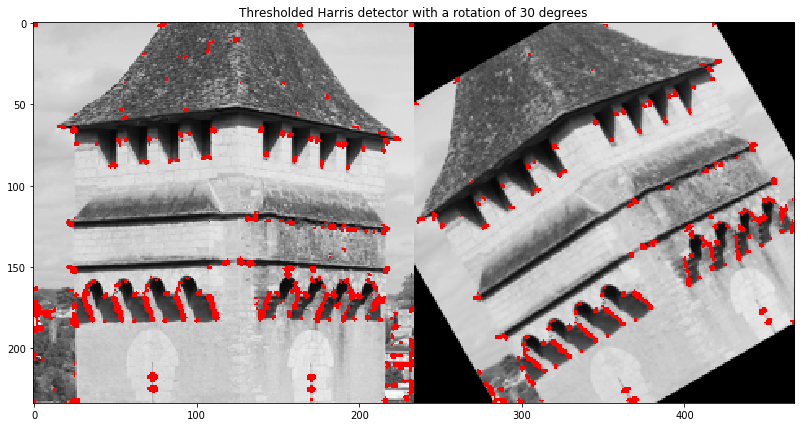

In [48]:
# Rotation
angle = 30
t = 0.1

imgb = rotate(img, angle)
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))

plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((threshold(val_h,t),threshold(imgb_h,t)))))
plt.title("Thresholded Harris detector with a rotation of {} degrees".format(angle))
plt.show()


The Harris detector seems to be robust against rotation.

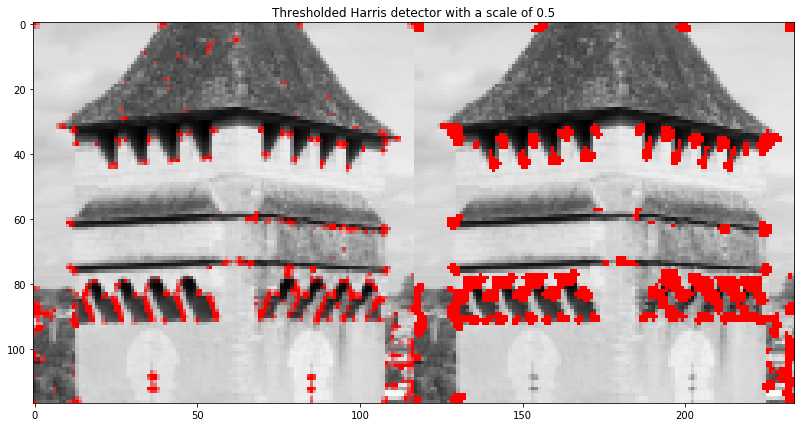

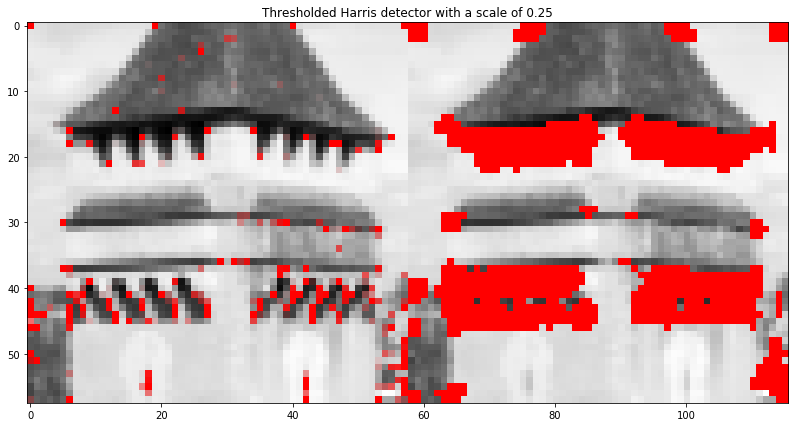

In [49]:
# Scale change
scale = [0.5,0.25]
t = 0.1

for i,s in enumerate(scale):
    imgb = rescale(img, s)
    imgb_h = corner_harris(imgb)

    scaled_a = resize(threshold(val_h,t), imgb.shape, anti_aliasing=False)
    
    plt.figure(figsize=(15,7))
    plt.imshow(np.hstack((imgb,imgb)),cmap='gray')


    plt.imshow(point_map(np.hstack((scaled_a,threshold(imgb_h,t)))))
    plt.title("Thresholded Harris detector with a scale of {}".format(s))
    
    plt.show()


Against scale changes the Harris detector tends to find the same regions but produces imprecise results. Fine tuning  the threshold would not be enough : on the one hand we would like to increase it so that thre are less detection but on the other hand in order to detect the vertical line at the bottom of the image we would need to lower the threshold level.

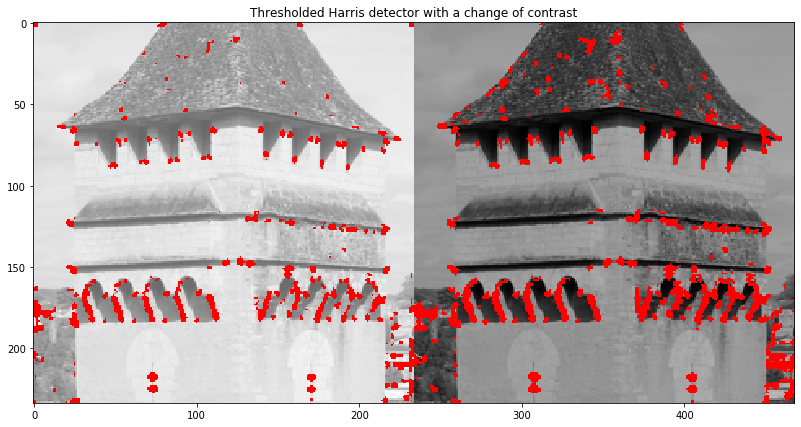

In [50]:
# Contrast change
t = 0.1

imgb = (img - img.mean()) * 1.25 + 0.1
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((threshold(val_h,t,fixed=True),threshold(imgb_h,t,fixed=True)))))
plt.title("Thresholded Harris detector with a change of contrast")
plt.show()


The Harris detector is fairly robust against contrast changes even if they change the correlation value obtained and thus would require changing the threshold.

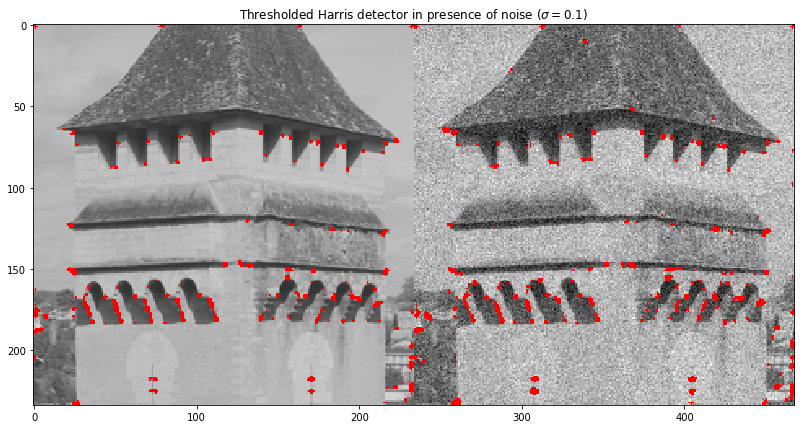

In [51]:
# Noise
sigma = 0.1

t = 0.1

imgb = img + sigma * np.random.randn(*img.shape)
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')


plt.imshow(point_map(np.hstack((threshold(val_h,t,fixed=False),threshold(imgb_h,t,fixed=False)))))
plt.title("Thresholded Harris detector in presence of noise ($\sigma ={}$)".format(sigma))
plt.show()


The Harris detector is also fairly robust against noise.

In [52]:
def median_pt_size(pts):
    # Computes the median size and the number of connected components in pts 
    labels, num = measure.label(pts, background=False, return_num=True)
    areas = np.zeros(num)
    for l in range(num):
        areas[l] = np.sum(labels == (l+1))
    return np.median(areas), num

def avrge_pt_size(pts):
    # Computes the average size and the number of connected components in pts
    labels, num = measure.label(pts, background=False, return_num=True)
    areas = np.zeros(num)
    for l in range(num):
        areas[l] = np.sum(labels == (l+1))
    return np.mean(areas), num


In [53]:
def img2list(img):
    w = np.where(img)
    return np.vstack(w).T

def matching(correlA, correlB, r=1.5):
    if correlA.dtype == float:
        correlA = correlA > 0.5 * correlA.max()
    if correlB.dtype == float:
        correlB = correlB > 0.5 * correlB.max()
    
    posA = img2list(correlA)
    posB = img2list(correlB)
    
    dist = cdist(posA, posB, metric='sqeuclidean')
    
    mindist = dist.min(axis=1)
    
    return np.sum(mindist < r*r)

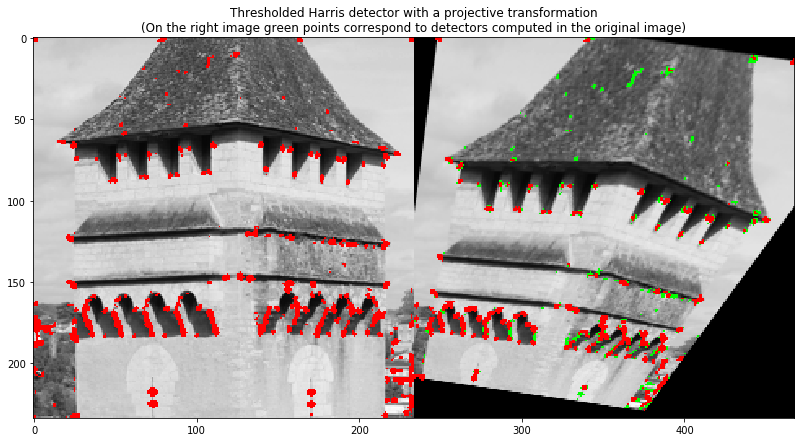

Proportion of matching points : 0.8548168249660787
Median point size : 8.0 Average point size 14.366863905325443


In [54]:
# Change of view point
t = 0.1

theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))

imgb = warp(img,trsfm.inverse,preserve_range=False)
imgb_h = corner_harris(imgb)

thld_a = threshold(val_h,t)
warped_ta = warp(thld_a.astype(float),trsfm.inverse,order=0)
thld_b = threshold(imgb_h,t)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(thld_a),warped_ta)),color=(0,1,0)))
plt.imshow(point_map(np.hstack((thld_a,thld_b))))
plt.title("Thresholded Harris detector with a projective transformation\n(On the right image green points correspond to detectors computed in the original image)")
plt.show()

print("Proportion of matching points :", matching(warped_ta,thld_b)/warped_ta.sum())
print("Median point size :", median_pt_size(thld_a)[0], "Average point size", avrge_pt_size(thld_a)[0])

When looking at the number of detected points that are also detected in the image with a change of view it appears that the Harris detector as good matching accuracy. However this is largely due to the facts that it is imprecise and detect regions instead of points as shown by the statistics displayed above.

### Quantitative results ###

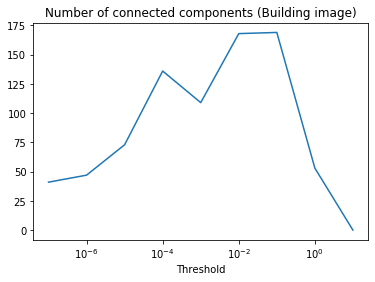

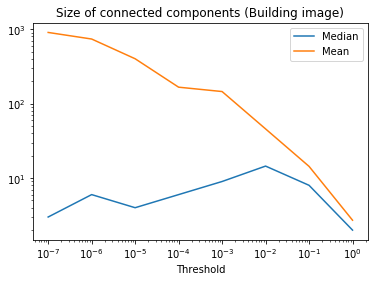

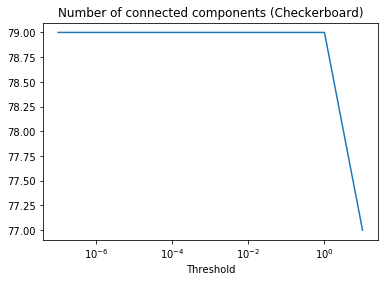

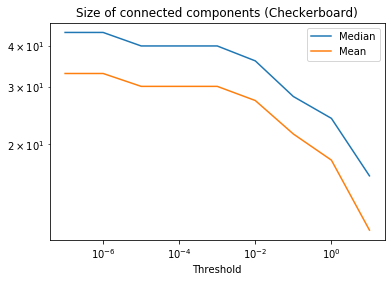

In [55]:
# Impact of the threshold
ts = [10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
results_sum = []
results_avg = []
results_med = []

corners = corner_harris(img)

for t in ts:
    pts = threshold(corners, t, fixed=True)
    avg, num = avrge_pt_size(pts)
    med, _ = median_pt_size(pts)
    results_sum.append(num)
    results_med.append(med)
    results_avg.append(avg)

plt.title('Number of connected components (Building image)')
plt.xlabel('Threshold')
plt.semilogx(ts, results_sum)
plt.show()

plt.title('Size of connected components (Building image)')
plt.xlabel('Threshold')
plt.loglog(ts, results_med, label='Median')
plt.loglog(ts, results_avg, label='Mean')
plt.legend()
plt.show()

results_sum = []
results_avg = []
results_med = []

corners = corner_harris(squares)

for t in ts:
    pts = threshold(corners, t, fixed=True)
    avg, num = avrge_pt_size(pts)
    med, _ = median_pt_size(pts)
    results_sum.append(num)
    results_med.append(med)
    results_avg.append(avg)

plt.title('Number of connected components (Checkerboard)')
plt.xlabel('Threshold')
plt.semilogx(ts, results_sum)
plt.show()

plt.title('Size of connected components (Checkerboard)')
plt.xlabel('Threshold')
plt.loglog(ts, results_med, label='Median')
plt.loglog(ts, results_avg, label='Mean')
plt.legend()
plt.show()

The results of the thresholded Harris detector need a good value for the treshold : if it is too high there will only be a few points detected, if it is too low the detected points will be imprecise and grouped together. These plots suggest to use 0.1 as the threshold value.

In [56]:
cat = ("Thresholded", "NMS", "ANMS")

results_scale = []
results_rotation = []
results_noise = []

results_scale_squares = []
results_rotation_squares = []
results_noise_squares = []

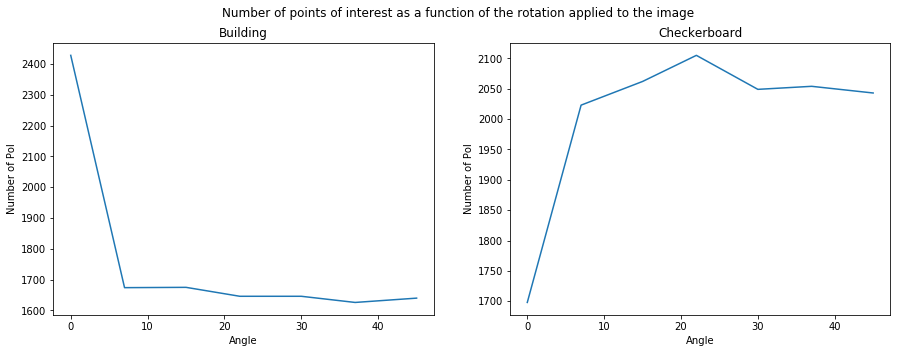

In [57]:
angles = [0,7,15,22,30,37,45]
results = []

t= 0.1

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = threshold(corners,t)
    results.append(harris.sum())

sresults = []

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = threshold(corners,t)
    sresults.append(harris.sum())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Angle")

plt.show()

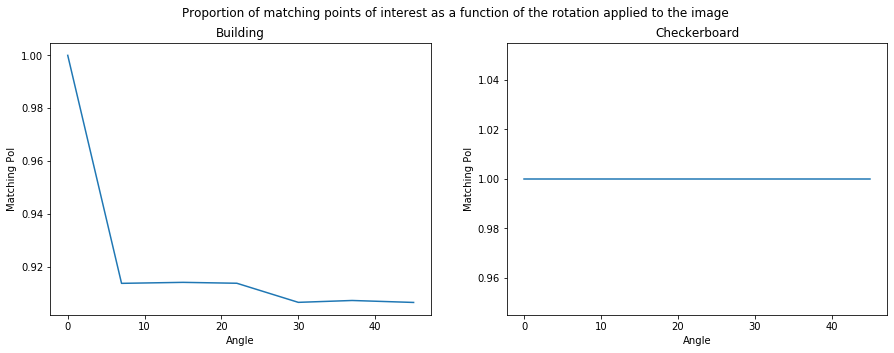

In [58]:
angles = [0,7,15,22,30,37,45]

results = []
t = 0.1

corners = corner_harris(img)
harris0 = threshold(corners, t).astype(float)

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = threshold(corners, t)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    results.append(matching(harris0_r, harris)/harris0_r.sum())

    
sresults = []

corners = corner_harris(squares)
harris0 = threshold(corners, t).astype(float)

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = threshold(corners, t)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    sresults.append(matching(harris0_r, harris)/harris0_r.sum())

results_rotation.append(results)
results_rotation_squares.append(sresults)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Angle")

plt.show()


Althougth the number of detection changes when a rotation is applied to the image we still get a good proportion of matching points. On the checkerboard pattern every detected point can be matched in the rotated image.

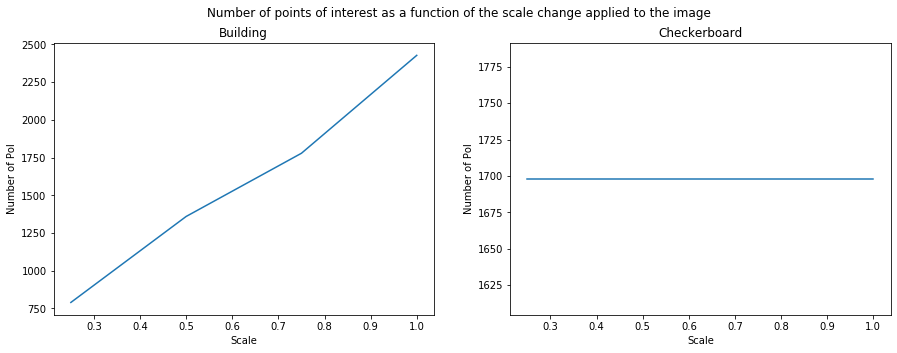

In [59]:
scales = [0.25,0.5,0.75,1]

results = []
for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = threshold(corners,t)
    results.append(harris.sum())
 
 

sresults = []
for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = threshold(corners,t)
    sresults.append(harris.sum())
 
 
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Scale")

plt.show()

The number of detected points varies with the scale of the image.

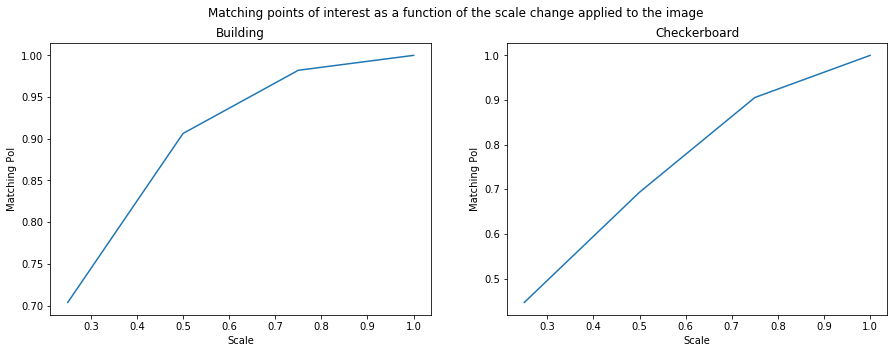

In [60]:
scales = [0.25,0.5,0.75,1]

results = []
t = 0.01

corners = corner_harris(img)
harris0 = threshold(corners, t).astype(float)

for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = threshold(corners, t)
    harris0_s = rescale(harris0, scale, order=0)
    results.append(matching(harris, harris0_s)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = threshold(corners, t).astype(float)

for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = threshold(corners, t)
    harris0_s = rescale(harris0, scale, order=0)
    sresults.append(matching(harris, harris0_s)/harris.sum())

results_scale.append(results)
results_scale_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Matching points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Scale")

plt.show()

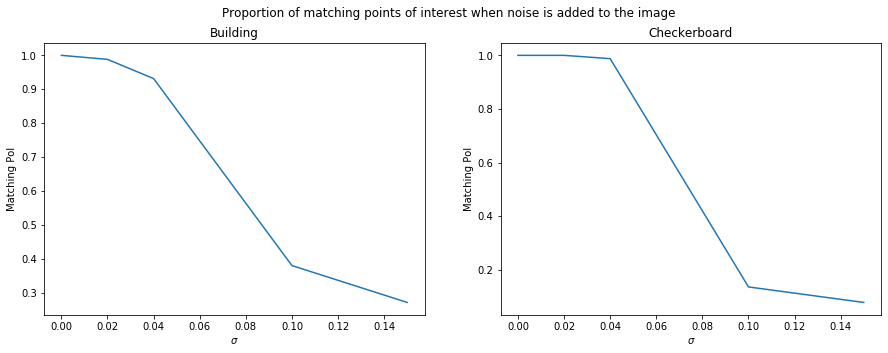

In [61]:
sigmas = [0,0.02,0.04,0.1,0.15]

results = []

imgb = img / img.max()
corners = corner_harris(imgb)
harris0 = threshold(corners, t)

for s in sigmas:
    imgn = imgb + s * np.random.randn(*imgb.shape)
    corners = corner_harris(imgn)
    harris = threshold(corners, t)
    results.append(matching(harris, harris0)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = threshold(corners, t)

for s in sigmas:
    imgn = squares + s * np.random.randn(*squares.shape)
    corners = corner_harris(imgn)
    harris = threshold(corners, t)
    sresults.append(matching(harris, harris0)/harris.sum())

results_noise.append(results)
results_noise_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest when noise is added to the image')
ax1.plot(sigmas, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

ax2.plot(sigmas, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

plt.show()

Performance of the Harris detector degrades when a noise with variance bigger than 0.04 is applied (for images with pixel values between 0 and 1).

# NMS ##

In [62]:
def nms(pts, r=1, c=0.9):
    # Apply non maximum suppression to pts
    maxmap = np.zeros_like(pts,dtype=int)
    impad = np.zeros((pts.shape[0]+2*r, pts.shape[1]+2*r))
    impad[:,:] = np.NINF
    impad[r:-r,r:-r] = pts
    for (i,j) in np.ndindex(pts.shape):
        maxmap[i,j] = (c * (impad[i:i+2*r+1,j:j+2*r+1]).max() <= pts[i,j])
    return maxmap

def t_nms(pts, t=0.1, r=1, c=0.9 ,fixed=True):
    # Apply NMS to the pixels of pts above a certain threshold
    return nms(pts, r, c) * threshold(pts, t, fixed)


### Qualitative experiments ###

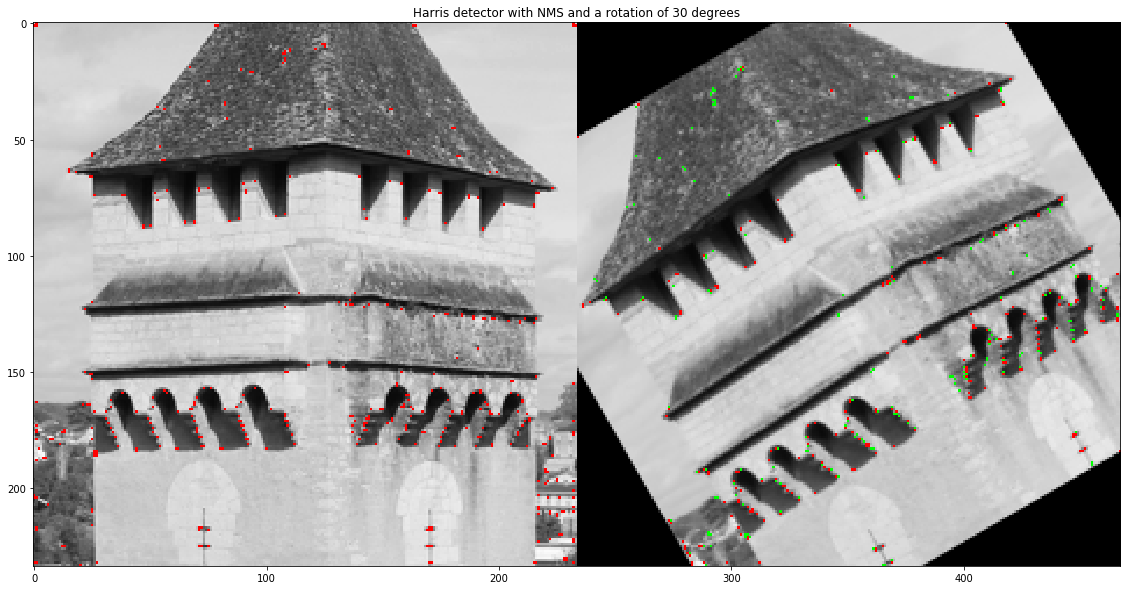

In [63]:
# Rotation
angle = 30
t = 0.1
r = 1
c = 0.9

imgb = rotate(img, angle)
imgb_h = corner_harris(imgb)

plt.figure(figsize=(20,10))

plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(img),rotate(t_nms(val_h,t,r,c).astype(float),angle,order=0))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((t_nms(val_h,t,r,c),t_nms(imgb_h,t,r,c)))))
plt.title("Harris detector with NMS and a rotation of {} degrees".format(angle))
plt.show()

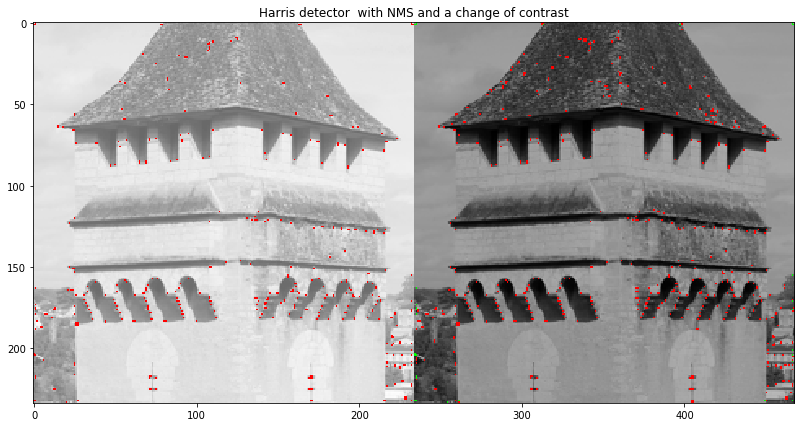

In [64]:
# Contrast change
t = 0.1
r = 1
c = 0.9

imgb = (img - img.mean()) * 1.25 + 0.1
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(img),t_nms(val_h,t,r,c))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((t_nms(val_h,t,r,c),t_nms(imgb_h,t,r,c)))))
plt.title("Harris detector  with NMS and a change of contrast")
plt.show()


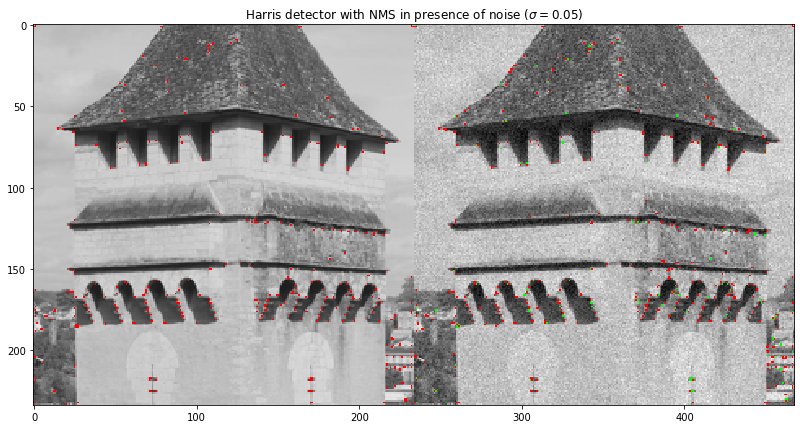

In [65]:
# Noise
sigma = 0.05

t = 0.1
r = 1
c = 0.9

imgb = img + sigma * np.random.randn(*img.shape)
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')


plt.imshow(point_map(np.hstack((np.zeros_like(img),t_nms(val_h,t,r,c))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((t_nms(val_h,t,r,c),t_nms(imgb_h,t,r,c)))))
plt.title("Harris detector with NMS in presence of noise ($\sigma ={}$)".format(sigma))
plt.show()


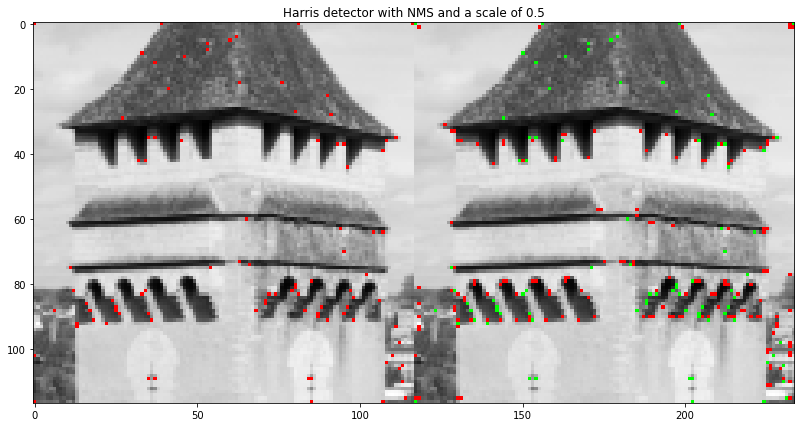

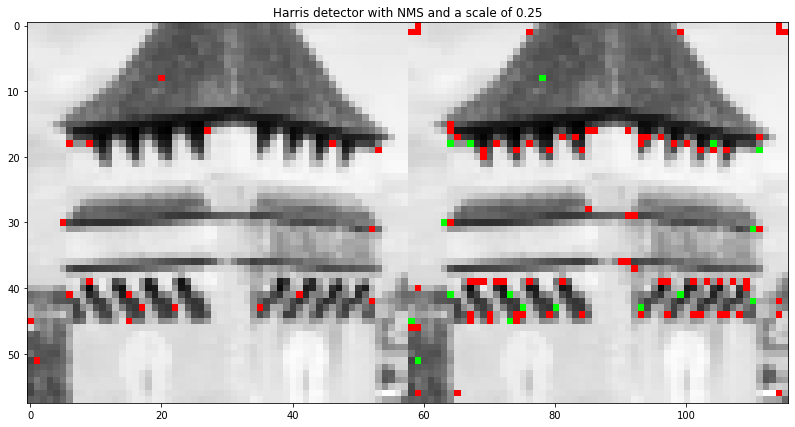

In [66]:
# Scale change
scale = [0.5,0.25]

t = 0.1
r = 1
c = 0.9

for i,s in enumerate(scale):
    imgb = rescale(img, s)
    imgb_h = corner_harris(imgb)

    scaled_a = resize(t_nms(val_h,t,r,c).astype(float), imgb.shape, anti_aliasing=False,order=0)
    
    img_s = resize(img, imgb.shape)
    
    plt.figure(figsize=(15,7))
    plt.imshow(np.hstack((img_s,imgb)),cmap='gray')

    plt.imshow(point_map(np.hstack((np.zeros_like(imgb),scaled_a)),color=(0,1,0)))
    plt.imshow(point_map(np.hstack((scaled_a,t_nms(imgb_h,t,r,c)))))
    
    plt.title("Harris detector with NMS and a scale of {}".format(s))
    
    plt.show()


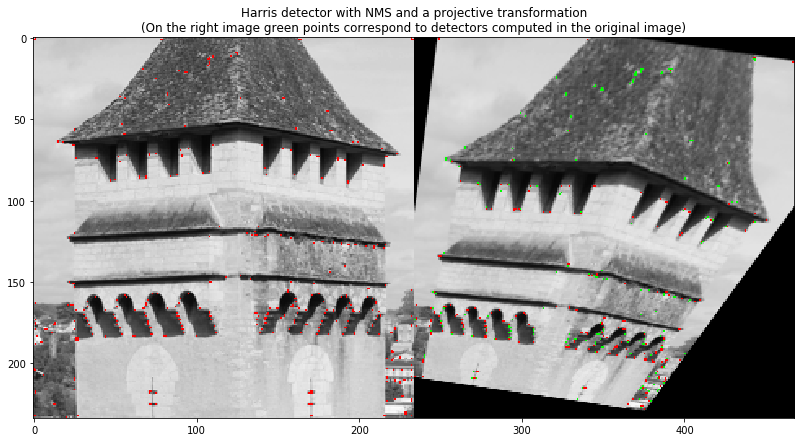

Proportion of matching points : 0.5912408759124088
Median point size : 1.0 Average point size 1.4640287769784173


In [67]:
# Change of view point
t = 0.1
r = 1
c = 0.9

theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))

imgb = warp(img,trsfm.inverse,preserve_range=False)
imgb_h = corner_harris(imgb)

thld_a = t_nms(val_h,t,r,c)
warped_ta = warp(thld_a.astype(float),trsfm.inverse,order=0)
thld_b = t_nms(imgb_h,t,r,c)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(thld_a),warped_ta)),color=(0,1,0)))
plt.imshow(point_map(np.hstack((thld_a,thld_b))))
plt.title("Harris detector with NMS and a projective transformation\n(On the right image green points correspond to detectors computed in the original image)")
plt.show()

print("Proportion of matching points :", matching(warped_ta,thld_b)/warped_ta.sum())
print("Median point size :", median_pt_size(thld_a)[0], "Average point size", avrge_pt_size(thld_a)[0])

Overall NMS yields less points that match points detected in transformed images but the points are more precise which is an important advantage against the simple thresholded Harris detector.

### Quantitative results ###

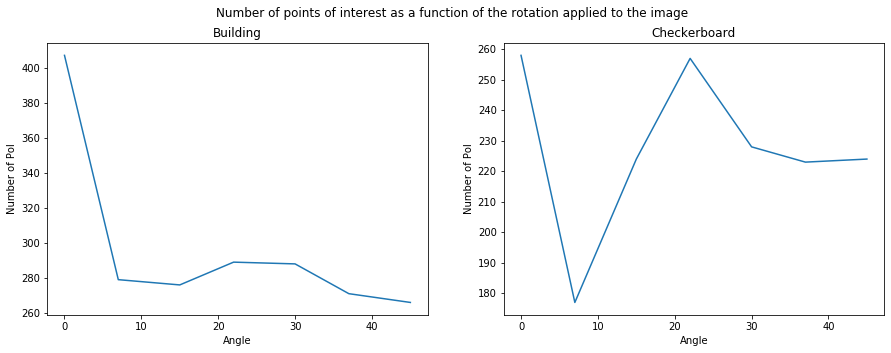

In [68]:
angles = [0,7,15,22,30,37,45]
results = []

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,t)
    results.append(harris.sum())

sresults = []

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,t)
    sresults.append(harris.sum())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Angle")

plt.show()

Once again the number of detected points changes with the orientation of the image, depending on the content of the image the behaviour is different.

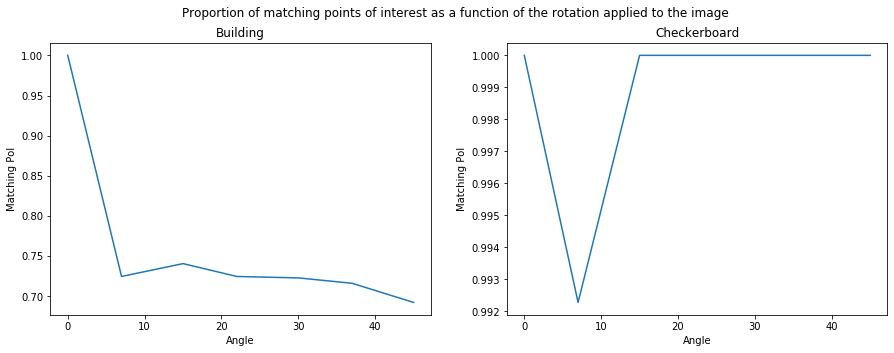

In [69]:
angles = [0,7,15,22,30,37,45]
results = []
t = 0.1

corners = corner_harris(img)
harris0 = t_nms(corners, t, r=1, c=0.9).astype(float)

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = t_nms(corners, t, r=1, c=0.9)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    results.append(matching(harris0_r, harris)/harris0_r.sum())

sresults = []

corners = corner_harris(squares)
harris0 = t_nms(corners, t, r=1, c=0.9).astype(float)

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = t_nms(corners, t, r=1, c=0.9)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    sresults.append(matching(harris0_r, harris)/harris0_r.sum())

results_rotation.append(results)
results_rotation_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Angle")

plt.show()


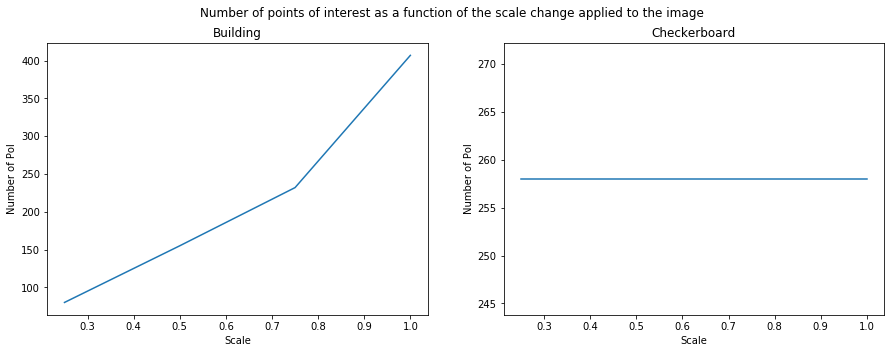

In [70]:
scales = [0.25,0.5,0.75,1]

results = []
for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,t)
    results.append(harris.sum())
 
 

sresults = []
for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,t)
    sresults.append(harris.sum())
 
 
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Scale")

plt.show()

The number of detected points varies with the scale of the image.

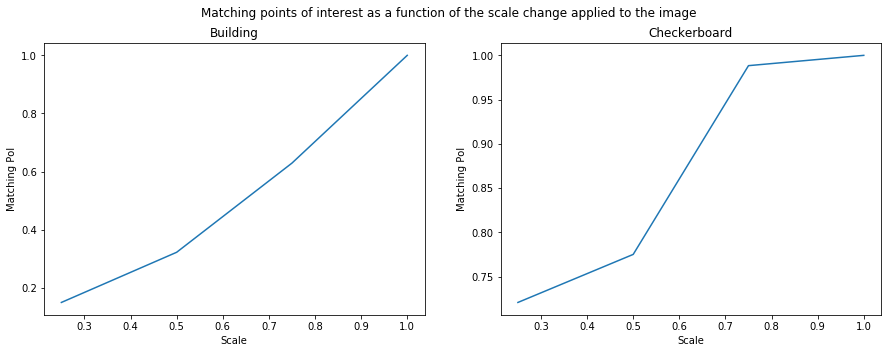

In [71]:
scales = [0.25,0.5,0.75,1]

results = []

corners = corner_harris(img)
harris0 = t_nms(corners).astype(float)

for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,t)
    harris0_s = rescale(harris0, scale, order=0)
    results.append(matching(harris, harris0_s)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = t_nms(corners).astype(float)

for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = t_nms(corners)
    harris0_s = rescale(harris0, scale, order=0)
    sresults.append(matching(harris, harris0_s)/harris.sum())

results_scale.append(results)
results_scale_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Matching points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Scale")

plt.show()

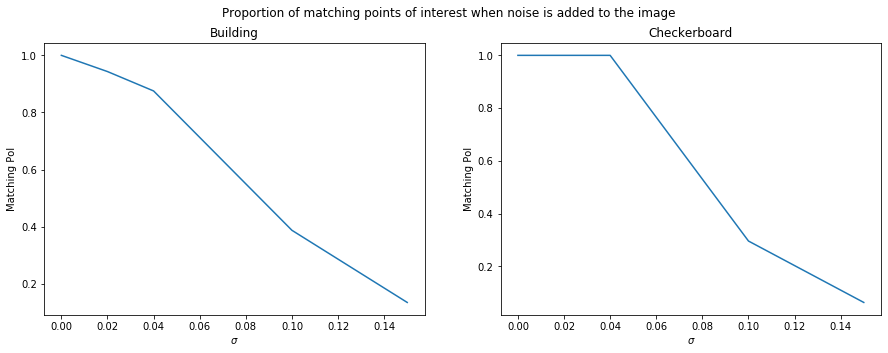

In [72]:
sigmas = [0,0.02,0.04,0.1,0.15]

results = []
t = 0.1

imgb = img / img.max()
corners = corner_harris(imgb)
harris0 = t_nms(corners,t).astype(float)

for s in sigmas:
    imgn = imgb + s * np.random.randn(*imgb.shape)
    corners = corner_harris(imgn)
    harris = t_nms(corners,t)
    results.append(matching(harris, harris0)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = t_nms(corners,t).astype(float)

for s in sigmas:
    imgn = squares + s * np.random.randn(*squares.shape)
    corners = corner_harris(imgn)
    harris = t_nms(corners,t)
    sresults.append(matching(harris, harris0)/harris.sum())

results_noise.append(results)
results_noise_squares.append(sresults)
   
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest when noise is added to the image')
ax1.plot(sigmas, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

ax2.plot(sigmas, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

plt.show()

Overall the number of matching points decreases when a transformation is applied to the image.

## ANMS ##

In [73]:
def anms(correl, n, t = 0.1, c=0.9, fixed = True):
    pts = threshold(correl, t, fixed=fixed)

    ic = 1/c
    width = pts.shape[1]
    
    detected = [(-correl[i,j],i,j) for i,j in np.ndindex(pts.shape) if pts[i,j]]
    detected.sort()
    detected = np.array(detected)
    
    detected_pos = np.array([[i,j] for _,i,j in detected])
    distances = squareform(pdist(detected_pos, metric='sqeuclidean'))
    
    rmap = np.zeros_like(correl)
    
    # Process the first point
    _,i,j = detected[0]
    rmap[int(i),int(j)] = - np.inf
    
    for k,(cor,i,j) in enumerate(detected[1:]):
        ccor = ic * cor
        k += 1
        
        bigger_processed = detected[:k,0] < ccor # We store -correl
        bigger_radius = distances[k,:k][bigger_processed]
        if len(bigger_radius) == 0:
            r = np.inf
        else:
            r = bigger_radius.min()
        rmap[int(i),int(j)] = -r
    
    # Extract the n best points
    pos = rmap.reshape(-1).argpartition(n)[:n]
    # Put the n best points in a 2D image
    res = np.zeros_like(pts)
    for p in pos:
        res[p // width, p % width] = True
    return res

### Qualitative experiments ###

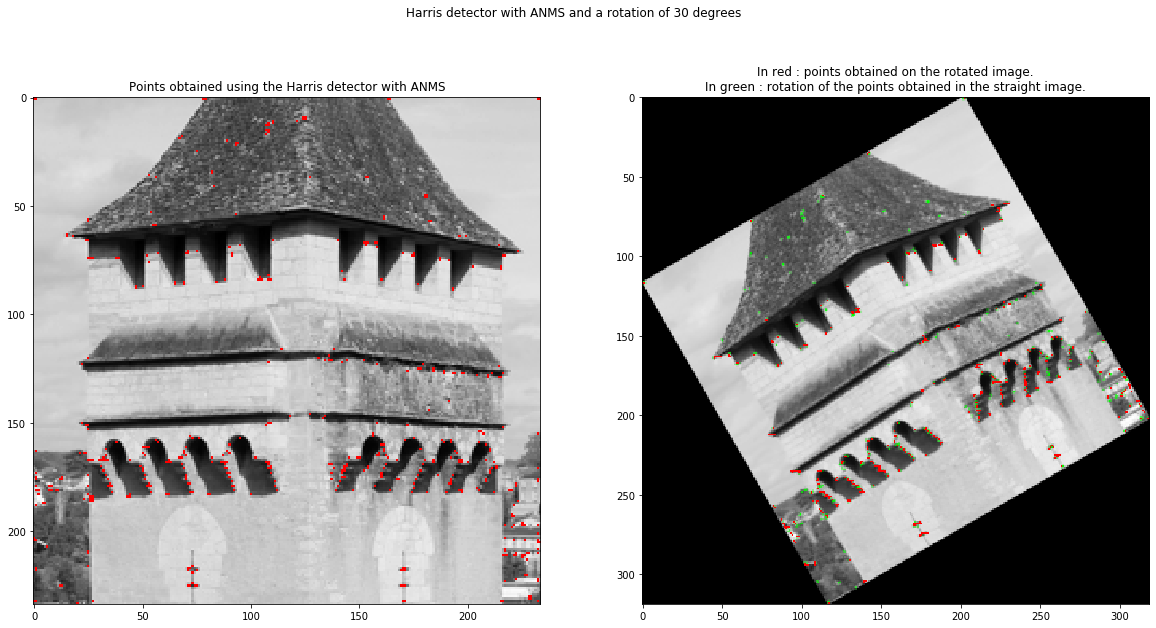

In [74]:
# Rotation
angle = 30
n = 500
t = 0.1
c = 0.9

imgb = rotate(img, angle, resize=True)
imgb_h = corner_harris(imgb)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Harris detector with ANMS and a rotation of {} degrees".format(angle))

ax1.imshow(img,cmap="gray")
ax1.imshow(point_map(anms(val_h,n,t,c)))
ax1.set_title("Points obtained using the Harris detector with ANMS")

ax2.imshow(imgb,cmap="gray")
ax2.imshow(point_map(rotate(anms(val_h,n,t,c),angle,resize=True),color=(0,1,0)))
ax2.imshow(point_map(anms(imgb_h,n,t,c)))
ax2.set_title("In red : points obtained on the rotated image.\nIn green : rotation of the points obtained in the straight image.")
plt.show()

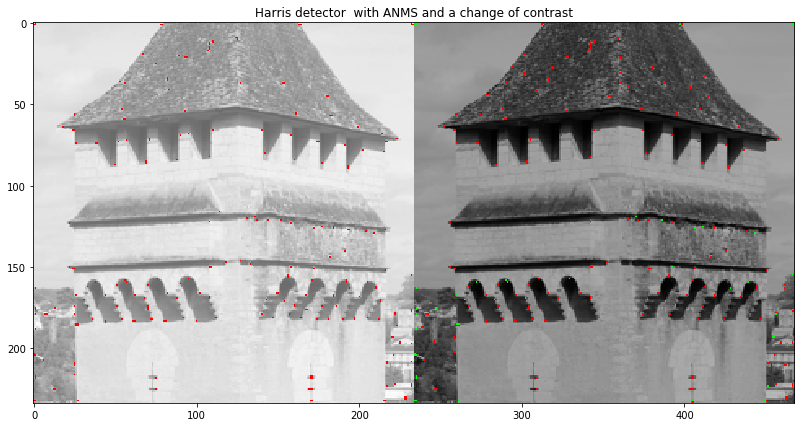

In [75]:
# Contrast change
n = 250
t = 0.1
c = 0.9

imgb = (img - img.mean()) * 1.25 + 0.1
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(img),anms(val_h,n,t,c))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((anms(val_h,n,t,c),anms(imgb_h,n,t,c)))))
plt.title("Harris detector  with ANMS and a change of contrast")
plt.show()

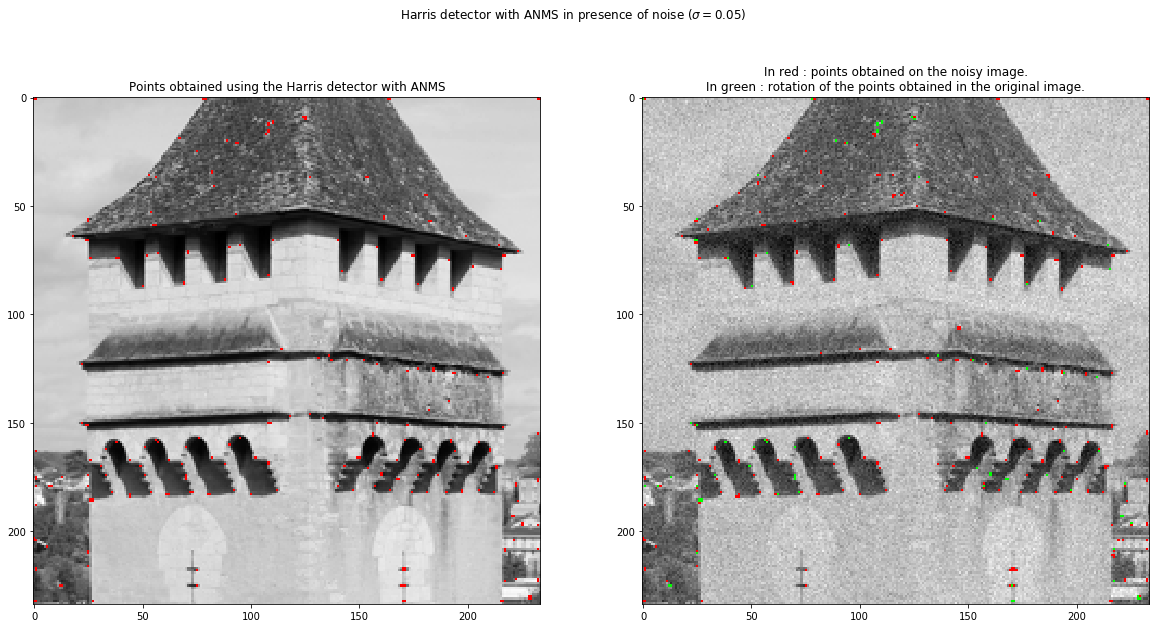

In [76]:
# Noise
sigma = 0.05

n = 250
t = 0.1
c = 0.9

imgb = img + sigma * np.random.randn(*img.shape)
imgb_h = corner_harris(imgb)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Harris detector with ANMS in presence of noise ($\sigma ={}$)".format(sigma))

ax1.imshow(img,cmap="gray")
ax1.imshow(point_map(anms(val_h,n,t,c)))
ax1.set_title("Points obtained using the Harris detector with ANMS")

ax2.imshow(imgb,cmap="gray")
ax2.imshow(point_map(anms(val_h,n,t,c),color=(0,1,0)))
ax2.imshow(point_map(anms(imgb_h,n,t,c)))
ax2.set_title("In red : points obtained on the noisy image.\nIn green : rotation of the points obtained in the original image.")
plt.show()


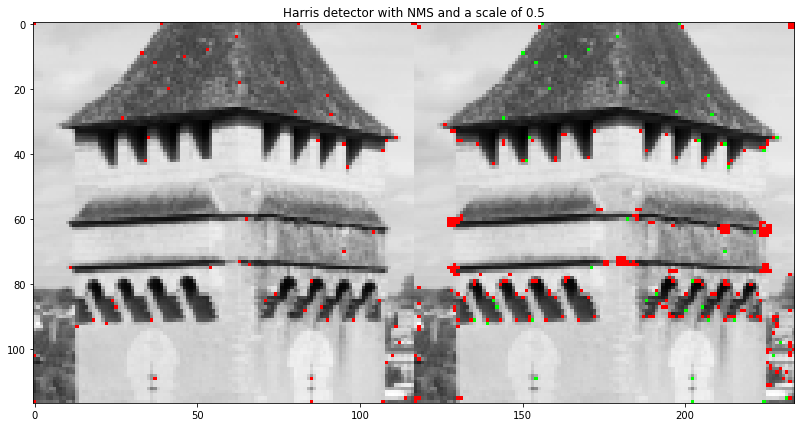

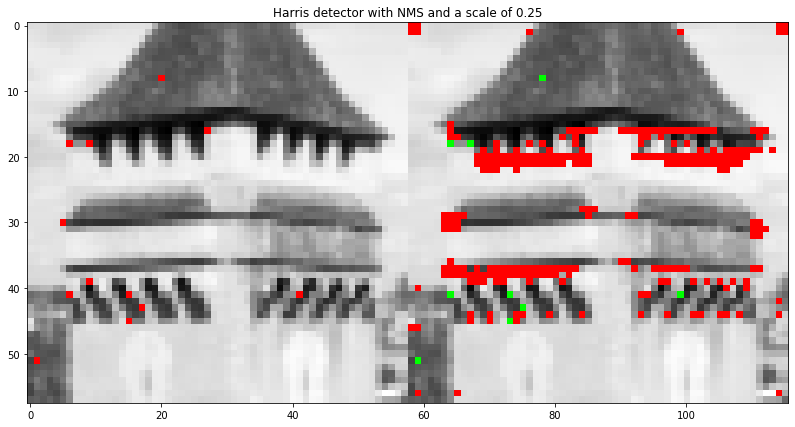

In [77]:
# Scale change
scale = [0.5,0.25]

n = 250
t = 0.1
c = 0.9

for i,s in enumerate(scale):
    imgb = rescale(img, s)
    imgb_h = corner_harris(imgb)

    scaled_a = resize(anms(val_h,n,t,c).astype(float), imgb.shape, anti_aliasing=False,order=0)
    
    img_s = resize(img, imgb.shape)
    
    plt.figure(figsize=(15,7))
    plt.imshow(np.hstack((img_s,imgb)),cmap='gray')

    plt.imshow(point_map(np.hstack((np.zeros_like(imgb),scaled_a)),color=(0,1,0)))
    plt.imshow(point_map(np.hstack((scaled_a,anms(imgb_h,n,t,c)))))
    
    plt.title("Harris detector with NMS and a scale of {}".format(s))
    
    plt.show()


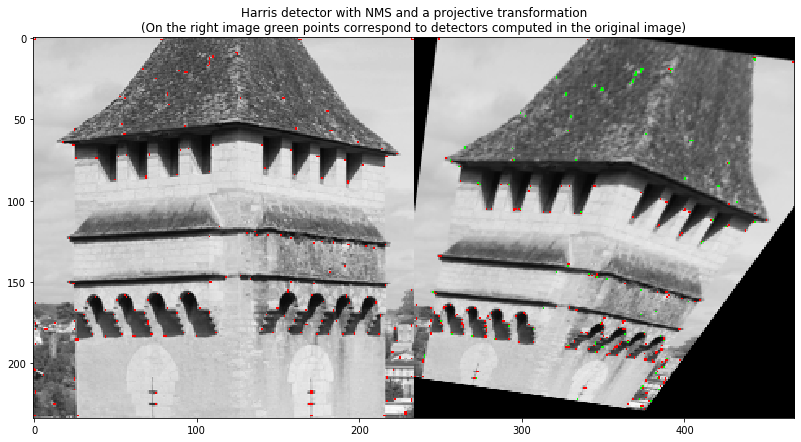

Proportion of matching points : 0.6704545454545454
Median point size : 1.0 Average point size 1.4285714285714286


In [78]:
# Change of view point
n = 250
t = 0.1 
c = 0.9

theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))

imgb = warp(img,trsfm.inverse,preserve_range=False)
imgb_h = corner_harris(imgb)

thld_a = anms(val_h,n,t,c)
warped_ta = warp(thld_a.astype(float),trsfm.inverse,order=0)
thld_b = anms(imgb_h,n,t,c)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(thld_a),warped_ta)),color=(0,1,0)))
plt.imshow(point_map(np.hstack((thld_a,thld_b))))
plt.title("Harris detector with NMS and a projective transformation\n(On the right image green points correspond to detectors computed in the original image)")
plt.show()

print("Proportion of matching points :", matching(warped_ta,thld_b)/warped_ta.sum())
print("Median point size :", median_pt_size(thld_a)[0], "Average point size", avrge_pt_size(thld_a)[0])

ANMS yield a good number of matching points with precise location. On top of that the number of points can easily be adjusted.

### Quantitative experiments ###

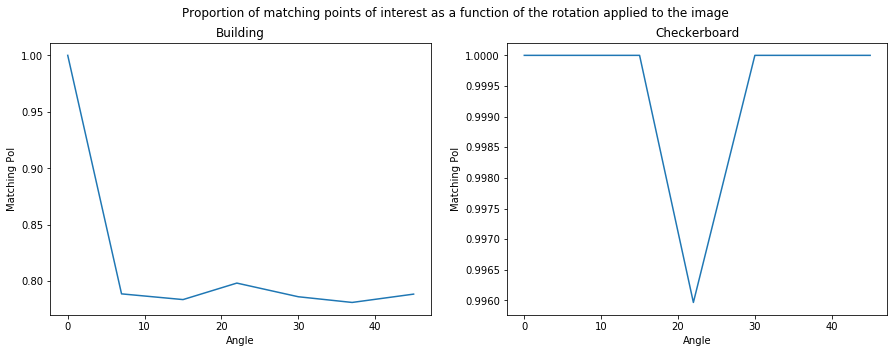

In [79]:
angles = [0,7,15,22,30,37,45]

n = 250
t = 0.1 
c = 0.9

results = []

corners = corner_harris(img)
harris0 = anms(corners, n, t, c).astype(float)

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = anms(corners, n, t, c)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    results.append(matching(harris0_r, harris)/harris0_r.sum())

sresults = []

corners = corner_harris(squares)
harris0 = anms(corners, n, t, c).astype(float)

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = anms(corners, n, t, c)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    sresults.append(matching(harris0_r, harris)/harris0_r.sum())

results_rotation.append(results)
results_rotation_squares.append(sresults)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Angle")

plt.show()


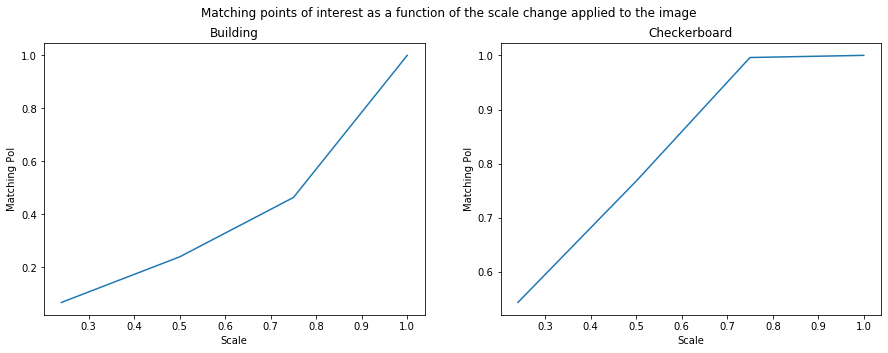

In [80]:
scales = [0.24,0.5,0.75,1]

n = 250
t = 0.1
c = 0.9

results = []

corners = corner_harris(img)
harris0 = anms(corners, n, t, c).astype(float)

for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = anms(corners, n, t, c)
    harris0_s = rescale(harris0, scale, order=0)
    results.append(matching(harris, harris0_s)/harris.sum())
    
sresults = []

corners = corner_harris(squares)
harris0 = anms(corners, n, t, c).astype(float)

for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = anms(corners, n, t, c)
    harris0_s = rescale(harris0, scale, order=0)
    sresults.append(matching(harris, harris0_s)/harris.sum())

results_scale.append(results)
results_scale_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Matching points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Scale")

plt.show()

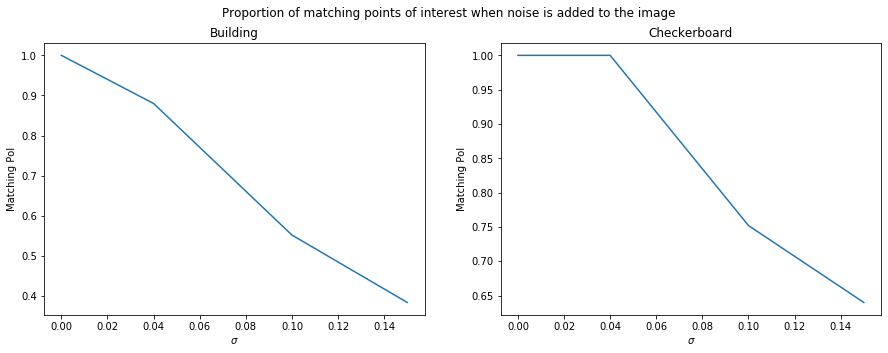

In [81]:
sigmas = [0,0.02,0.04,0.1,0.15]

n = 250
t = 0.1 
c = 0.9

results = []

imgb = img / img.max()
corners = corner_harris(imgb)
harris0 = anms(corners, n, t, c)

for s in sigmas:
    imgn = imgb + s * np.random.randn(*imgb.shape)
    corners = corner_harris(imgn)
    harris = anms(corners, n, t, c)
    results.append(matching(harris, harris0)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = anms(corners, n, t, c)

for s in sigmas:
    imgn = squares + s * np.random.randn(*squares.shape)
    corners = corner_harris(imgn)
    harris = anms(corners, n, t, c)
    sresults.append(matching(harris, harris0)/harris.sum())

results_noise.append(results)
results_noise_squares.append(sresults)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest when noise is added to the image')
ax1.plot(sigmas, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

ax2.plot(sigmas, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

plt.show()

When a transformation is applied to the image the number of matching points decreases. However there is always at least 50 correspondance remaining and those are really precise.

## Summary ##

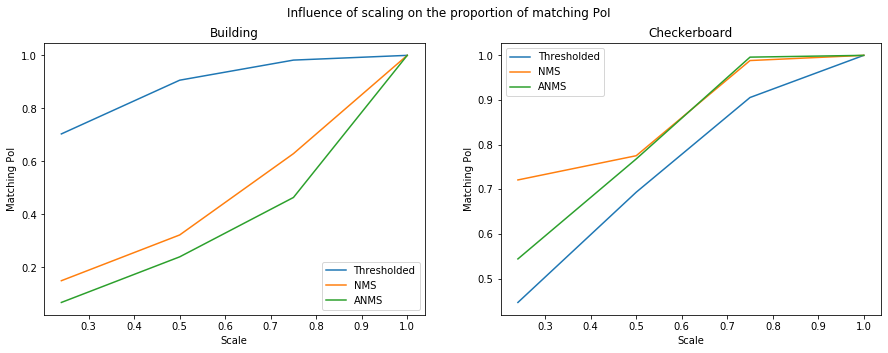

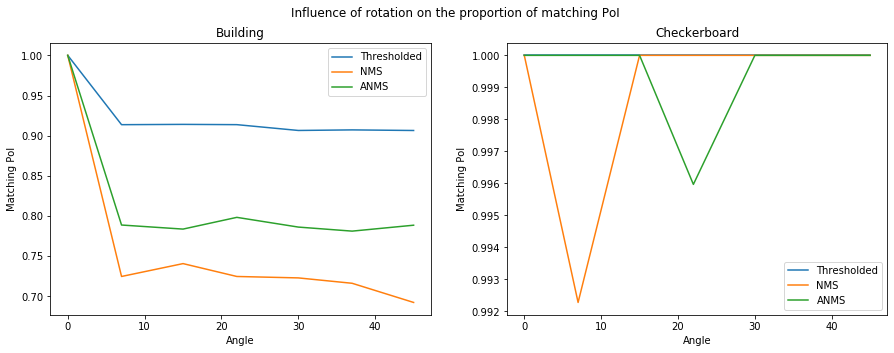

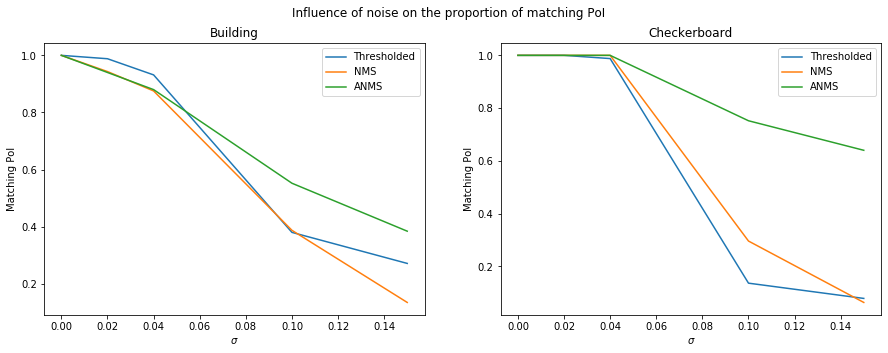

In [82]:
# Scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Influence of scaling on the proportion of matching PoI')
for i, label in enumerate(cat):
    ax1.plot(scales, results_scale[i], label=label)
ax1.set_title("Building")
ax1.legend()
ax1.set(ylabel = "Matching PoI", xlabel = "Scale")

for i, label in enumerate(cat):
    ax2.plot(scales, results_scale_squares[i], label=label)
ax2.set_title("Checkerboard")
ax2.legend()
ax2.set(ylabel = "Matching PoI", xlabel = "Scale")

plt.show()

# Rotation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Influence of rotation on the proportion of matching PoI')
for i, label in enumerate(cat):
    ax1.plot(angles, results_rotation[i], label=label)
ax1.set_title("Building")
ax1.legend()
ax1.set(ylabel = "Matching PoI", xlabel = "Angle")

for i, label in enumerate(cat):
    ax2.plot(angles, results_rotation_squares[i], label=label)
ax2.set_title("Checkerboard")
ax2.legend()
ax2.set(ylabel = "Matching PoI", xlabel = "Angle")

plt.show()

# Noise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Influence of noise on the proportion of matching PoI')
for i, label in enumerate(cat):
    ax1.plot(sigmas, results_noise[i], label=label)
ax1.set_title("Building")
ax1.legend()
ax1.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

for i, label in enumerate(cat):
    ax2.plot(sigmas, results_noise_squares[i], label=label)
ax2.set_title("Checkerboard")
ax2.legend()
ax2.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

plt.show()



In [83]:
# Change of view point
t = 0.1

theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))

thld_a = threshold(val_h,t)
nms_a = t_nms(val_h, t)
anms_a = anms(val_h, 250, t)

thld_b = threshold(squares_h,t)
nms_b = t_nms(squares_h, t)
anms_b = anms(squares_h, 250, t)

print("Threshold :")
print("  Building:")
print("    Number of connected components :", median_pt_size(thld_a)[1])
print("    Median point size : {} ".format(int(median_pt_size(thld_a)[0])))
print("    Average point size : {:.2f}".format(avrge_pt_size(thld_a)[0]))
print("  Checkerboard:")
print("    Number of connected components :", median_pt_size(thld_b)[1])
print("    Median point size : {} ".format(int(median_pt_size(thld_b)[0])))
print("    Average point size : {:.2f}".format(avrge_pt_size(thld_b)[0]))

print("NMS :")
print("  Building:")
print("    Number of connected components :", median_pt_size(nms_a)[1])
print("    Median point size : {} ".format(int(median_pt_size(nms_a)[0])))
print("    Average point size : {:.2f}".format(avrge_pt_size(nms_a)[0]))
print("  Checkerboard:")
print("    Number of connected components :", median_pt_size(nms_b)[1])
print("    Median point size : {} ".format(int(median_pt_size(nms_b)[0])))
print("    Average point size : {:.2f}".format(avrge_pt_size(nms_b)[0]))

print("ANMS :")
print("  Building:")
print("    Number of connected components :", median_pt_size(anms_a)[1])
print("    Median point size : {} ".format(int(median_pt_size(anms_a)[0])))
print("    Average point size : {:.2f}".format(avrge_pt_size(anms_a)[0]))
print("  Checkerboard:")
print("    Number of connected components :", median_pt_size(anms_b)[1])
print("    Median point size : {} ".format(int(median_pt_size(anms_b)[0])))
print("    Average point size : {:.2f}".format(avrge_pt_size(anms_b)[0]))


Threshold :
  Building:
    Number of connected components : 169
    Median point size : 8 
    Average point size : 14.37
  Checkerboard:
    Number of connected components : 79
    Median point size : 28 
    Average point size : 21.49
NMS :
  Building:
    Number of connected components : 278
    Median point size : 1 
    Average point size : 1.46
  Checkerboard:
    Number of connected components : 79
    Median point size : 4 
    Average point size : 3.27
ANMS :
  Building:
    Number of connected components : 175
    Median point size : 1 
    Average point size : 1.43
  Checkerboard:
    Number of connected components : 79
    Median point size : 4 
    Average point size : 3.16


The thresholded Harris detector is fairly robust to image transformation but only provide un precise points. NMS and ANMS have less points that match a transformation but they provide a précise location and the RANSAC algorithm can later be used to remove outliers.